In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
from scipy.constants import mu_0

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import CasingSimulations

from pymatsolver import Pardiso

import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
sigma_back = 1e-1 # wholespace

# top casing source
cp = CasingSimulations.CasingParameters(
    casing_l = 1000.,
    src_a = np.r_[0., np.pi, 0.], # the source fcts will take care of coupling it to the casing
    src_b = np.r_[1e3, np.pi, 0.], # return electrode  
    freqs = np.r_[0.1],
    sigma_back = sigma_back, # wholespace
    sigma_layer = sigma_back,
    sigma_air = sigma_back,
    
)
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.1,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.1],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 0.1,
 'sigma_back': 0.1,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0]}

In [3]:
cp.skin_depth()

array([ 5000.])

# Set up meshes

In [17]:
npadx, npadz = 11, 26
dx2 = 200. 
csz = 0.25

mesh2D = CasingSimulations.CasingMesh(
    cp=cp, npadx=npadx, npadz=npadz, dx2=dx2, csz=csz
).mesh

In [18]:
ncy = 3
nstretchy = 3
stretchfact = 1.4
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

In [19]:
mesh3D = CasingSimulations.CasingMesh(
    cp=cp, npadx=npadx, npadz=npadz, dx2=dx2, hy=hy, csz=csz
).mesh

In [20]:
print(mesh2D.nC, mesh3D.nC)

(316836, 2851524)


In [21]:
mesh2D.vectorCCx.max()

5631.097412109375

In [24]:
# TODO: this should go into the cyl mesh view
self = mesh3D
NN = utils.ndgrid(self.vectorNx, self.vectorNy, np.r_[0])[:,:2]
NN = NN.reshape((self.vnN[0], self.vnN[1], 2), order='F')
NN = [NN[:,:,0], NN[:,:,1]]

In [25]:
print(NN[1].shape, self.nCx)

((79, 9), 78)


In [26]:
from discretize.utils import mkvc

In [27]:
X1 = np.c_[mkvc(NN[0][0, :]), mkvc(NN[0][self.nCx, :]), mkvc(NN[0][0, :])*np.nan].flatten()
Y1 = np.c_[mkvc(NN[1][0, :]), mkvc(NN[1][self.nCx, :]), mkvc(NN[1][0, :])*np.nan].flatten()

(0.0, 1000.0)

//anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


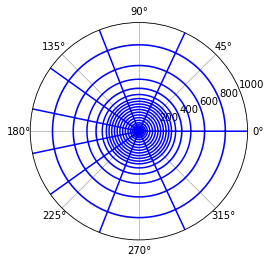

In [28]:
ax = plt.subplot(111, projection='polar')
ax.plot(Y1, X1, 'b-')
n = 100
xy2 = [ax.plot(np.linspace(0., np.pi*2, n), r*np.ones(n), '-b') for r in self.vectorNx]
ax.set_rlim([0., 1000.])


In [29]:
src2D = CasingSimulations.Sources.TopCasingSource(mesh2D, cp)

In [30]:
src3D = CasingSimulations.Sources.TopCasingSource(mesh3D, cp)

(-0.5, 0.5)

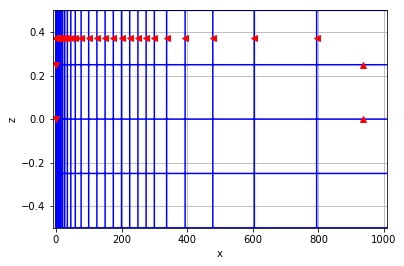

In [32]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src2D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-1., 1.])

(-0.5, 0.5)

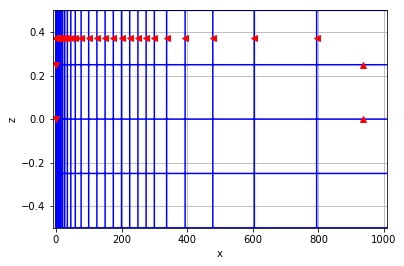

In [34]:
fig, ax = plt.subplots(1,1)
mesh2D.plotGrid(ax=ax)
src3D.plot(ax=ax)
ax.set_xlim([-10,1010.])
ax.set_ylim(0.5*np.r_[-1., 1.])

In [35]:
# validate the source terms
src3D.validate()
src2D.validate()

True

(0.0, 1500)

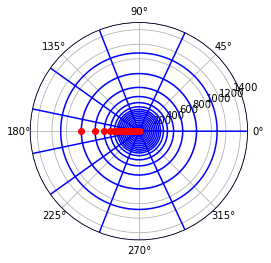

In [36]:
ax = plt.subplot(111, projection='polar')
ax.plot(Y1, X1, 'b-')
n = 100
xy2 = [ax.plot(np.linspace(0., np.pi*2, n), r*np.ones(n), '-b') for r in self.vectorNx[1:]]
ax.plot(mesh3D.gridFx[src3D.surface_wire,1], mesh3D.gridFx[src3D.surface_wire,0], 'ro')
ax.set_rlim([0., 1500])

# Look at physical properties on mesh

In [37]:
physprops2D = CasingSimulations.PhysicalProperties(mesh2D, cp)
physprops3D = CasingSimulations.PhysicalProperties(mesh3D, cp)

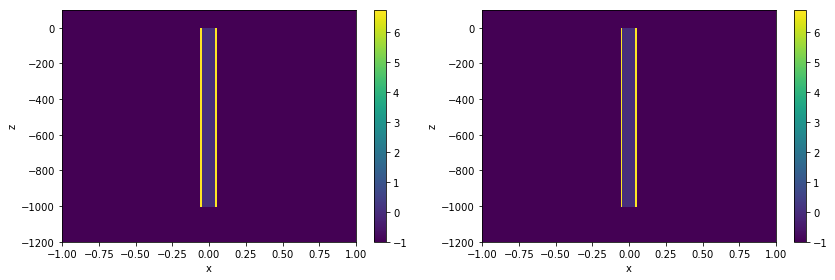

In [38]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(np.log10(physprops2D.sigma), ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

sigmaplt = physprops3D.sigma.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(np.log10(utils.mkvc(sigmaplt[:,0,:])), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

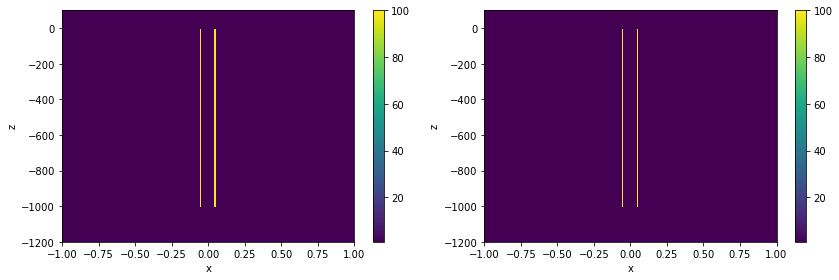

In [39]:
xlim = [-1., 1]
ylim = [-1200., 100.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.colorbar(
    mesh2D.plotImage(physprops2D.mur, ax=ax[0], mirror=True)[0], ax=ax[0]
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

murplt = physprops3D.mur.reshape(mesh3D.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[1], mirror=True)[0], ax=ax[1])
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

# set up the forward simulation

In [40]:
prb2D = FDEM.Problem3D_h(
    mesh2D, sigmaMap=physprops2D.wires.sigma, muMap=physprops2D.wires.mu, Solver=Pardiso
)
prb3D = FDEM.Problem3D_h(
    mesh3D, sigmaMap=physprops3D.wires.sigma, muMap=physprops3D.wires.mu, Solver=Pardiso
)

In [41]:
survey2D = FDEM.Survey(src2D.srcList)
survey3D = FDEM.Survey(src3D.srcList)

In [42]:
prb2D.pair(survey2D)
prb3D.pair(survey3D)

In [43]:
%%time

fields2D = prb2D.fields(physprops2D.model)

CPU times: user 3.72 s, sys: 687 ms, total: 4.41 s
Wall time: 3.25 s


In [ ]:
%%time

fields3D = prb3D.fields(physprops3D.model)